可用的中文字体: ['Noto Serif CJK JP', 'Noto Serif CJK JP', 'Noto Sans CJK JP', 'Noto Sans CJK JP', 'Noto Serif CJK JP']
使用字体: Noto Serif CJK JP
成功读取数据，共 152 条记录
数据列: ['name', 'address', 'desc']


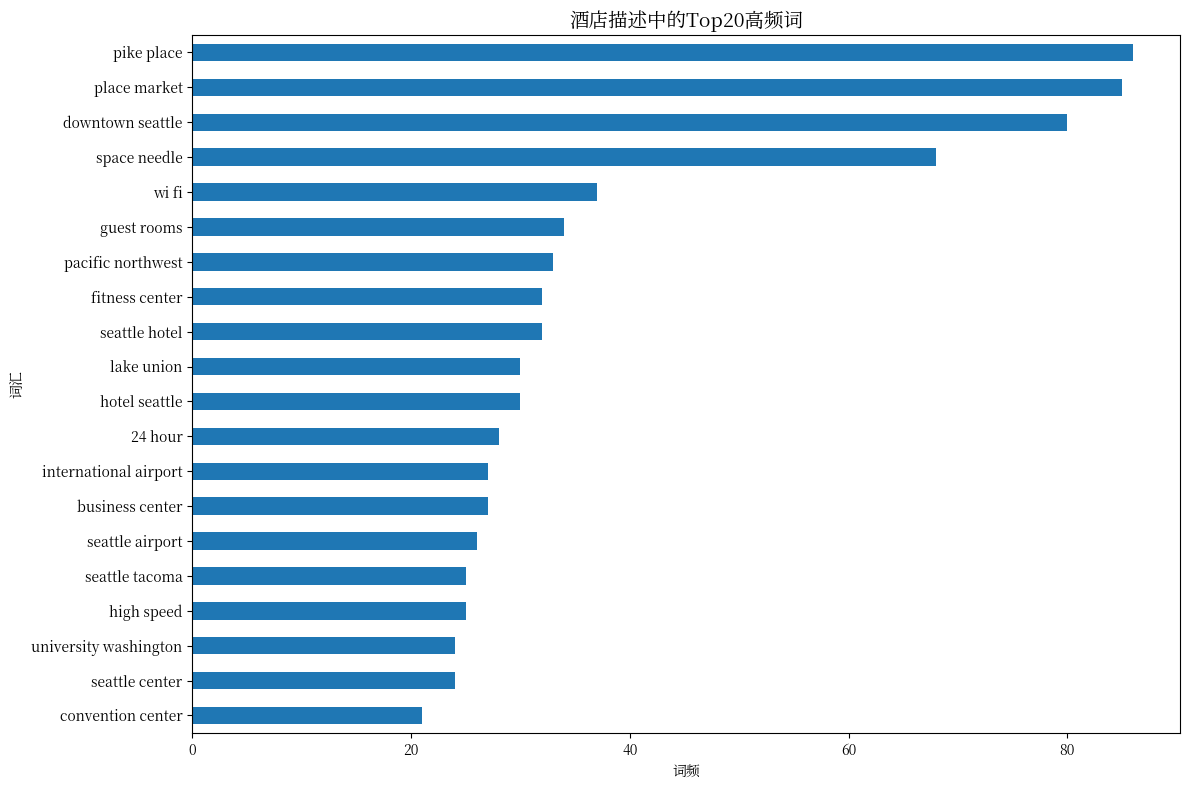

In [10]:
import pandas as pd
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import matplotlib.pyplot as plt
import numpy as np

# 设置pandas显示选项
pd.options.display.max_columns = 30

# 修复中文字体显示问题
import matplotlib
import matplotlib.font_manager as fm

# 创建英文停用词列表
ENGLISH_STOPWORDS = {
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 
    'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', 
    "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 
    'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 
    'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 
    'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 
    'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 
    'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 
    'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 
    "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', 
    "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', 
    "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 
    'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"
}

# 查找可用的中文字体
chinese_fonts = [f.name for f in fm.fontManager.ttflist if 'CJK' in f.name or 'Chinese' in f.name]
print("可用的中文字体:", chinese_fonts[:5])

# 设置字体
if chinese_fonts:
    # 使用系统中可用的中文字体
    matplotlib.rcParams['font.sans-serif'] = [chinese_fonts[0]] + matplotlib.rcParams['font.sans-serif']
    print(f"使用字体: {chinese_fonts[0]}")
else:
    # 如果没有找到中文字体，使用默认字体并显示英文
    print("警告: 未找到中文字体，图表标题将显示英文")
    matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']

matplotlib.rcParams['axes.unicode_minus'] = False

# 读取数据
try:
    df = pd.read_csv('../../data/Seattle_Hotels.csv', encoding="latin-1")
    print(f"成功读取数据，共 {len(df)} 条记录")
    print(f"数据列: {list(df.columns)}")
    df.head()
except FileNotFoundError:
    print("数据文件未找到，创建示例数据...")
    # 创建示例数据
    sample_data = {
        'name': ['豪华酒店A', '商务酒店B', '度假酒店C', '经济型酒店D', '精品酒店E'],
        'desc': [
            '位于市中心的豪华五星级酒店，提供优质服务和设施',
            '商务旅行者的理想选择，靠近商业区，设施齐全',
            '海滨度假胜地，风景优美，适合休闲度假',
            '经济实惠的住宿选择，干净舒适，交通便利',
            '独特的精品酒店，个性化服务，艺术氛围浓厚'
        ],
        'rating': [4.8, 4.2, 4.5, 3.8, 4.6],
        'price': [500, 300, 400, 150, 350]
    }
    df = pd.DataFrame(sample_data)
    print("使用示例数据")
    df.head()

# 文本分析函数
def get_top_n_words(corpus, n=1, k=None):
    """
    获取文本语料库中n-gram特征的前k个高频词
    
    参数:
    corpus: 文本语料库
    n: n-gram的n值
    k: 返回的高频词数量
    """
    # 统计ngram词频矩阵
    vec = CountVectorizer(ngram_range=(n, n), stop_words=list(ENGLISH_STOPWORDS)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    # 按照词频从大到小排序
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:k]

# 分析酒店描述中的高频词
if 'desc' in df.columns:
    common_words = get_top_n_words(df['desc'], 2, 20)
    df1 = pd.DataFrame(common_words, columns=['word', 'count'])
    
    # 绘制词频图
    plt.figure(figsize=(12, 8))
    df1.groupby('word').sum()['count'].sort_values().plot(kind='barh')
    
    # 根据字体可用性设置标题
    if chinese_fonts:
        plt.title('酒店描述中的Top20高频词', fontsize=14)
    else:
        plt.title('Top 20 Most Frequent Words in Hotel Descriptions', fontsize=14)
    
    plt.xlabel('Frequency' if not chinese_fonts else '词频')
    plt.ylabel('Words' if not chinese_fonts else '词汇')
    plt.tight_layout()
    plt.show()
else:
    print("数据中没有'desc'列")

In [11]:
# 文本预处理
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
# 使用自定义的英文停用词列表替代nltk的stopwords
STOPWORDS = ENGLISH_STOPWORDS
# 对文本进行清洗
def clean_text(text):
    # 全部小写
    text = text.lower()
    # 用空格替代一些特殊符号，如标点
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    # 移除BAD_SYMBOLS_RE
    text = BAD_SYMBOLS_RE.sub('', text)
    # 从文本中去掉停用词
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    return text
# 对desc字段进行清理，apply针对某列
df['desc_clean'] = df['desc'].apply(clean_text)

In [12]:
# 建模
df.set_index('name', inplace = True)
# 使用TF-IDF提取文本特征，使用自定义停用词列表
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0.01, stop_words=list(ENGLISH_STOPWORDS))
# 针对desc_clean提取tfidf
tfidf_matrix = tf.fit_transform(df['desc_clean'])
print('TFIDF feature names:')
print(tf.get_feature_names_out())
print(len(tf.get_feature_names_out()))
print('tfidf_matrix:')
print(tfidf_matrix)
print(tfidf_matrix.shape)
# 计算酒店之间的余弦相似度（线性核函数）
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)
print(cosine_similarities)
print(cosine_similarities.shape)

TFIDF feature names:
['000' '000 sq' '000 sq ft' ... 'yummy' 'zones' 'zoo']
3347
tfidf_matrix:
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16877 stored elements and shape (152, 3347)>
  Coords	Values
  (0, 1719)	0.0653556302128929
  (0, 1626)	0.12491293982326873
  (0, 3081)	0.134097856000268
  (0, 1369)	0.07476039423996281
  (0, 1221)	0.07672194770445162
  (0, 1543)	0.049246645770058876
  (0, 2523)	0.04723838259568511
  (0, 820)	0.03267781510644645
  (0, 1413)	0.027559455988603942
  (0, 2190)	0.08406257987423404
  (0, 435)	0.08558268592593565
  (0, 1653)	0.067048928000134
  (0, 2018)	0.057864011823134734
  (0, 1387)	0.04979549787130613
  (0, 1781)	0.07132229854860234
  (0, 1564)	0.05628009710194575
  (0, 622)	0.08406257987423404
  (0, 1519)	0.050359388872797
  (0, 174)	0.06462486666561425
  (0, 1248)	0.0872351140221
  (0, 367)	0.09098742549726888
  (0, 1877)	0.09098742549726888
  (0, 1223)	0.0872351140221
  (0, 1127)	0.09098742549726888
  (0, 867)	0.0788903444584315
 

In [14]:
indices = pd.Series(df.index) #df.index是酒店名称

# 基于相似度矩阵和指定的酒店name，推荐TOP10酒店
def recommendations(name, cosine_similarities = cosine_similarities):
    recommended_hotels = []
    # 找到想要查询酒店名称的idx
    idx = indices[indices == name].index[0]
    print('idx=', idx)
    # 对于idx酒店的余弦相似度向量按照从大到小进行排序
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending = False)
    # 取相似度最大的前10个（除了自己以外）
    top_10_indexes = list(score_series.iloc[1:11].index)
    # 放到推荐列表中
    for i in top_10_indexes:
        recommended_hotels.append(list(df.index)[i])
    return recommended_hotels
print(recommendations('Hilton Seattle Airport & Conference Center'))
print(recommendations('The Bacon Mansion Bed and Breakfast'))

idx= 49
['Embassy Suites by Hilton Seattle Tacoma International Airport', 'DoubleTree by Hilton Hotel Seattle Airport', 'Seattle Airport Marriott', 'Four Points by Sheraton Downtown Seattle Center', 'Motel 6 Seattle Sea-Tac Airport South', 'Hampton Inn Seattle/Southcenter', 'Radisson Hotel Seattle Airport', 'Knights Inn Tukwila', 'Hotel Hotel', 'Home2 Suites by Hilton Seattle Airport']
idx= 116
['11th Avenue Inn Bed and Breakfast', 'Shafer Baillie Mansion Bed & Breakfast', 'Gaslight Inn', 'Bed and Breakfast Inn Seattle', 'Chittenden House Bed and Breakfast', 'Hyatt House Seattle', 'Mozart Guest House', 'Silver Cloud Hotel - Seattle Broadway', 'WorldMark Seattle - The Camlin', 'Pensione Nichols Bed and Breakfast']
